<h2>Introduction</h2>

In this competition, participants must help robots recognize the floor surface they’re standing on using data collected from sensors.

In [49]:
import os
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold
import lightgbm as lgb
sns.set()
#classfication report
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, make_scorer

print("Files in the input folder:")
#print(os.listdir("../input"))
train = pd.read_csv('X_trainnn.csv')
test = pd.read_csv('X_testtt.csv')
y = pd.read_csv('y_train.csv')
#sub = pd.read_csv('../input/sample_submission.csv')
print("\nX_train shape: {}, X_test shape: {}".format(train.shape, test.shape))
#print("y_train shape: {}, submission shape: {}".format(y.shape, sub.shape))

Files in the input folder:

X_train shape: (487680, 13), X_test shape: (488448, 13)


In [14]:
train.head()

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
0,0_0,0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532
1,0_1,0,1,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003385,0.33995,1.5064,-9.4128
2,0_2,0,2,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267
3,0_3,0,3,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960
4,0_4,0,4,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410


<h2>Feature Engineering</h2>

In [15]:
def feature_extraction(raw_frame):
    frame = pd.DataFrame()
    raw_frame['angular_velocity'] = raw_frame['angular_velocity_X'] + raw_frame['angular_velocity_Y'] + raw_frame['angular_velocity_Z']
    raw_frame['linear_acceleration'] = raw_frame['linear_acceleration_X'] + raw_frame['linear_acceleration_Y'] + raw_frame['linear_acceleration_Y']
    raw_frame['velocity_to_acceleration'] = raw_frame['angular_velocity'] / raw_frame['linear_acceleration']
    
    for col in raw_frame.columns[3:]:
        frame[col + '_mean'] = raw_frame.groupby(['series_id'])[col].mean()
        frame[col + '_std'] = raw_frame.groupby(['series_id'])[col].std()
        frame[col + '_max'] = raw_frame.groupby(['series_id'])[col].max()
        frame[col + '_min'] = raw_frame.groupby(['series_id'])[col].min()
        frame[col + '_max_to_min'] = frame[col + '_max'] / frame[col + '_min']
        
        frame[col + '_mean_abs_change'] = raw_frame.groupby('series_id')[col].apply(lambda x: np.mean(np.abs(np.diff(x))))
        frame[col + '_abs_max'] = raw_frame.groupby('series_id')[col].apply(lambda x: np.max(np.abs(x)))
    return frame

In [16]:
train_df = feature_extraction(train)
test_df = feature_extraction(test)
train_df.head()

,orientation_X_mean,orientation_X_std,orientation_X_max,orientation_X_min,orientation_X_max_to_min,orientation_X_mean_abs_change,orientation_X_abs_max,orientation_Y_mean,orientation_Y_std,orientation_Y_max,...,linear_acceleration_max_to_min,linear_acceleration_mean_abs_change,linear_acceleration_abs_max,velocity_to_acceleration_mean,velocity_to_acceleration_std,velocity_to_acceleration_max,velocity_to_acceleration_min,velocity_to_acceleration_max_to_min,velocity_to_acceleration_mean_abs_change,velocity_to_acceleration_abs_max
series_id,,,,,,,,,,,,,,,,,,,,,
0,-0.758666,0.000363,-0.75822,-0.75953,0.998275,0.000015,0.75953,-0.634008,0.000471,-0.63306,...,-440.912422,1.507869,12.03250,0.023497,0.222562,2.444038,-0.163152,-14.980095,0.057500,2.444038
1,-0.958606,0.000151,-0.95837,-0.95896,0.999385,0.000023,0.95896,0.241867,0.000499,0.24270,...,-2.994224,2.680602,12.51448,0.006958,0.115248,1.157278,-0.258428,-4.478137,0.057504,1.157278
2,-0.512057,0.001377,-0.50944,-0.51434,0.990473,0.000041,0.51434,-0.846171,0.000785,-0.84490,...,-4.462653,1.855546,12.92295,0.049577,0.405777,4.445092,-0.336429,-13.212587,0.111821,4.445092
3,-0.939169,0.000227,-0.93884,-0.93968,0.999106,0.000026,0.93968,0.310140,0.000453,0.31147,...,-1.675275,3.938777,23.71235,-0.007084,0.202459,0.536344,-1.437307,-0.373159,0.086081,1.437307
4,-0.891301,0.002955,-0.88673,-0.89689,0.988672,0.000080,0.89689,0.428144,0.006165,0.43740,...,16.236353,0.645448,9.82879,-0.021466,0.026864,0.011489,-0.166277,-0.069095,0.007255,0.166277


In [17]:
t=train_df.reset_index()
a=test_df.reset_index()

In [19]:
df2=pd.read_csv("y_train.csv")

In [20]:
t2=df2.iloc[:,:2]

In [24]:
work=pd.merge(t,df2,on="series_id")

In [25]:
work.head()

,series_id,orientation_X_mean,orientation_X_std,orientation_X_max,orientation_X_min,orientation_X_max_to_min,orientation_X_mean_abs_change,orientation_X_abs_max,orientation_Y_mean,orientation_Y_std,...,linear_acceleration_abs_max,velocity_to_acceleration_mean,velocity_to_acceleration_std,velocity_to_acceleration_max,velocity_to_acceleration_min,velocity_to_acceleration_max_to_min,velocity_to_acceleration_mean_abs_change,velocity_to_acceleration_abs_max,group_id,surface
0,0,-0.758666,0.000363,-0.75822,-0.75953,0.998275,0.000015,0.75953,-0.634008,0.000471,...,12.03250,0.023497,0.222562,2.444038,-0.163152,-14.980095,0.057500,2.444038,13,fine_concrete
1,1,-0.958606,0.000151,-0.95837,-0.95896,0.999385,0.000023,0.95896,0.241867,0.000499,...,12.51448,0.006958,0.115248,1.157278,-0.258428,-4.478137,0.057504,1.157278,31,concrete
2,2,-0.512057,0.001377,-0.50944,-0.51434,0.990473,0.000041,0.51434,-0.846171,0.000785,...,12.92295,0.049577,0.405777,4.445092,-0.336429,-13.212587,0.111821,4.445092,20,concrete
3,3,-0.939169,0.000227,-0.93884,-0.93968,0.999106,0.000026,0.93968,0.310140,0.000453,...,23.71235,-0.007084,0.202459,0.536344,-1.437307,-0.373159,0.086081,1.437307,31,concrete
4,4,-0.891301,0.002955,-0.88673,-0.89689,0.988672,0.000080,0.89689,0.428144,0.006165,...,9.82879,-0.021466,0.026864,0.011489,-0.166277,-0.069095,0.007255,0.166277,22,soft_tiles


In [26]:
me=pd.merge(a,t2, how='left', on=['series_id'])

In [27]:
me.head()

,series_id,orientation_X_mean,orientation_X_std,orientation_X_max,orientation_X_min,orientation_X_max_to_min,orientation_X_mean_abs_change,orientation_X_abs_max,orientation_Y_mean,orientation_Y_std,...,linear_acceleration_mean_abs_change,linear_acceleration_abs_max,velocity_to_acceleration_mean,velocity_to_acceleration_std,velocity_to_acceleration_max,velocity_to_acceleration_min,velocity_to_acceleration_max_to_min,velocity_to_acceleration_mean_abs_change,velocity_to_acceleration_abs_max,group_id
0,0,-0.025810,0.000284,-0.025156,-0.026418,0.952230,0.000055,0.026418,-0.988644,0.000039,...,3.041678,12.78267,-0.000155,0.037663,0.142076,-0.305222,-0.465485,0.023029,0.305222,13.0
1,1,-0.932288,0.000564,-0.931480,-0.933720,0.997601,0.000021,0.933720,0.330271,0.001654,...,1.603404,12.59892,-0.016115,0.101334,0.178999,-0.944607,-0.189496,0.039707,0.944607,31.0
2,2,-0.230186,0.001054,-0.227130,-0.231410,0.981505,0.000093,0.231410,0.961448,0.000260,...,4.847992,18.43390,-0.012139,0.143982,0.860221,-1.002650,-0.857947,0.084303,1.002650,20.0
3,3,0.164661,0.001182,0.167500,0.163320,1.025594,0.000037,0.167500,0.975293,0.000182,...,0.592315,7.64826,0.003921,0.004727,0.016386,-0.006052,-2.707672,0.002819,0.016386,31.0
4,4,-0.253600,0.009763,-0.236370,-0.269380,0.877459,0.000260,0.269380,0.955712,0.002578,...,0.319687,8.15349,-0.025923,0.008230,-0.007225,-0.041543,0.173905,0.002212,0.041543,22.0


In [28]:
work=work.drop(labels="series_id",axis=1)
me=me.drop(labels="series_id",axis=1)

In [29]:
features=work.iloc[:,:92]
le = LabelEncoder()
target = le.fit_transform(y['surface'])

In [30]:
features.head()

,orientation_X_mean,orientation_X_std,orientation_X_max,orientation_X_min,orientation_X_max_to_min,orientation_X_mean_abs_change,orientation_X_abs_max,orientation_Y_mean,orientation_Y_std,orientation_Y_max,...,linear_acceleration_mean_abs_change,linear_acceleration_abs_max,velocity_to_acceleration_mean,velocity_to_acceleration_std,velocity_to_acceleration_max,velocity_to_acceleration_min,velocity_to_acceleration_max_to_min,velocity_to_acceleration_mean_abs_change,velocity_to_acceleration_abs_max,group_id
0,-0.758666,0.000363,-0.75822,-0.75953,0.998275,0.000015,0.75953,-0.634008,0.000471,-0.63306,...,1.507869,12.03250,0.023497,0.222562,2.444038,-0.163152,-14.980095,0.057500,2.444038,13
1,-0.958606,0.000151,-0.95837,-0.95896,0.999385,0.000023,0.95896,0.241867,0.000499,0.24270,...,2.680602,12.51448,0.006958,0.115248,1.157278,-0.258428,-4.478137,0.057504,1.157278,31
2,-0.512057,0.001377,-0.50944,-0.51434,0.990473,0.000041,0.51434,-0.846171,0.000785,-0.84490,...,1.855546,12.92295,0.049577,0.405777,4.445092,-0.336429,-13.212587,0.111821,4.445092,20
3,-0.939169,0.000227,-0.93884,-0.93968,0.999106,0.000026,0.93968,0.310140,0.000453,0.31147,...,3.938777,23.71235,-0.007084,0.202459,0.536344,-1.437307,-0.373159,0.086081,1.437307,31
4,-0.891301,0.002955,-0.88673,-0.89689,0.988672,0.000080,0.89689,0.428144,0.006165,0.43740,...,0.645448,9.82879,-0.021466,0.026864,0.011489,-0.166277,-0.069095,0.007255,0.166277,22


In [37]:
##working on missing values on test
features.columns

Index(['orientation_X_mean', 'orientation_X_std', 'orientation_X_max',
       'orientation_X_min', 'orientation_X_max_to_min',
       'orientation_X_mean_abs_change', 'orientation_X_abs_max',
       'orientation_Y_mean', 'orientation_Y_std', 'orientation_Y_max',
       'orientation_Y_min', 'orientation_Y_max_to_min',
       'orientation_Y_mean_abs_change', 'orientation_Y_abs_max',
       'orientation_Z_mean', 'orientation_Z_std', 'orientation_Z_max',
       'orientation_Z_min', 'orientation_Z_max_to_min',
       'orientation_Z_mean_abs_change', 'orientation_Z_abs_max',
       'orientation_W_mean', 'orientation_W_std', 'orientation_W_max',
       'orientation_W_min', 'orientation_W_max_to_min',
       'orientation_W_mean_abs_change', 'orientation_W_abs_max',
       'angular_velocity_X_mean', 'angular_velocity_X_std',
       'angular_velocity_X_max', 'angular_velocity_X_min',
       'angular_velocity_X_max_to_min', 'angular_velocity_X_mean_abs_change',
       'angular_velocity_X_abs_max'

In [35]:
from fancyimpute import KNN
tes = KNN(k=5).fit_transform(me)

Using TensorFlow backend.


Imputing row 1/3816 with 0 missing, elapsed time: 8.272
Imputing row 101/3816 with 0 missing, elapsed time: 8.273
Imputing row 201/3816 with 0 missing, elapsed time: 8.273
Imputing row 301/3816 with 0 missing, elapsed time: 8.274
Imputing row 401/3816 with 0 missing, elapsed time: 8.274
Imputing row 501/3816 with 0 missing, elapsed time: 8.274
Imputing row 601/3816 with 0 missing, elapsed time: 8.275
Imputing row 701/3816 with 0 missing, elapsed time: 8.275
Imputing row 801/3816 with 0 missing, elapsed time: 8.275
Imputing row 901/3816 with 0 missing, elapsed time: 8.276
Imputing row 1001/3816 with 0 missing, elapsed time: 8.276
Imputing row 1101/3816 with 0 missing, elapsed time: 8.276
Imputing row 1201/3816 with 0 missing, elapsed time: 8.277
Imputing row 1301/3816 with 0 missing, elapsed time: 8.277
Imputing row 1401/3816 with 0 missing, elapsed time: 8.278
Imputing row 1501/3816 with 0 missing, elapsed time: 8.278
Imputing row 1601/3816 with 0 missing, elapsed time: 8.278
Imputing 

In [36]:
tes=pd.DataFrame(tes)

In [38]:
tes.columns=['orientation_X_mean', 'orientation_X_std', 'orientation_X_max',
       'orientation_X_min', 'orientation_X_max_to_min',
       'orientation_X_mean_abs_change', 'orientation_X_abs_max',
       'orientation_Y_mean', 'orientation_Y_std', 'orientation_Y_max',
       'orientation_Y_min', 'orientation_Y_max_to_min',
       'orientation_Y_mean_abs_change', 'orientation_Y_abs_max',
       'orientation_Z_mean', 'orientation_Z_std', 'orientation_Z_max',
       'orientation_Z_min', 'orientation_Z_max_to_min',
       'orientation_Z_mean_abs_change', 'orientation_Z_abs_max',
       'orientation_W_mean', 'orientation_W_std', 'orientation_W_max',
       'orientation_W_min', 'orientation_W_max_to_min',
       'orientation_W_mean_abs_change', 'orientation_W_abs_max',
       'angular_velocity_X_mean', 'angular_velocity_X_std',
       'angular_velocity_X_max', 'angular_velocity_X_min',
       'angular_velocity_X_max_to_min', 'angular_velocity_X_mean_abs_change',
       'angular_velocity_X_abs_max', 'angular_velocity_Y_mean',
       'angular_velocity_Y_std', 'angular_velocity_Y_max',
       'angular_velocity_Y_min', 'angular_velocity_Y_max_to_min',
       'angular_velocity_Y_mean_abs_change', 'angular_velocity_Y_abs_max',
       'angular_velocity_Z_mean', 'angular_velocity_Z_std',
       'angular_velocity_Z_max', 'angular_velocity_Z_min',
       'angular_velocity_Z_max_to_min', 'angular_velocity_Z_mean_abs_change',
       'angular_velocity_Z_abs_max', 'linear_acceleration_X_mean',
       'linear_acceleration_X_std', 'linear_acceleration_X_max',
       'linear_acceleration_X_min', 'linear_acceleration_X_max_to_min',
       'linear_acceleration_X_mean_abs_change',
       'linear_acceleration_X_abs_max', 'linear_acceleration_Y_mean',
       'linear_acceleration_Y_std', 'linear_acceleration_Y_max',
       'linear_acceleration_Y_min', 'linear_acceleration_Y_max_to_min',
       'linear_acceleration_Y_mean_abs_change',
       'linear_acceleration_Y_abs_max', 'linear_acceleration_Z_mean',
       'linear_acceleration_Z_std', 'linear_acceleration_Z_max',
       'linear_acceleration_Z_min', 'linear_acceleration_Z_max_to_min',
       'linear_acceleration_Z_mean_abs_change',
       'linear_acceleration_Z_abs_max', 'angular_velocity_mean',
       'angular_velocity_std', 'angular_velocity_max', 'angular_velocity_min',
       'angular_velocity_max_to_min', 'angular_velocity_mean_abs_change',
       'angular_velocity_abs_max', 'linear_acceleration_mean',
       'linear_acceleration_std', 'linear_acceleration_max',
       'linear_acceleration_min', 'linear_acceleration_max_to_min',
       'linear_acceleration_mean_abs_change', 'linear_acceleration_abs_max',
       'velocity_to_acceleration_mean', 'velocity_to_acceleration_std',
       'velocity_to_acceleration_max', 'velocity_to_acceleration_min',
       'velocity_to_acceleration_max_to_min',
       'velocity_to_acceleration_mean_abs_change',
       'velocity_to_acceleration_abs_max', 'group_id']

In [41]:
tes["group_id"]=round(tes["group_id"])

In [42]:
tes.tail()

,orientation_X_mean,orientation_X_std,orientation_X_max,orientation_X_min,orientation_X_max_to_min,orientation_X_mean_abs_change,orientation_X_abs_max,orientation_Y_mean,orientation_Y_std,orientation_Y_max,...,linear_acceleration_mean_abs_change,linear_acceleration_abs_max,velocity_to_acceleration_mean,velocity_to_acceleration_std,velocity_to_acceleration_max,velocity_to_acceleration_min,velocity_to_acceleration_max_to_min,velocity_to_acceleration_mean_abs_change,velocity_to_acceleration_abs_max,group_id
3811,0.589010,0.001364,0.59145,0.58690,1.007753,0.000040,0.59145,0.794881,0.001040,0.79655,...,2.665016,13.20453,-0.000279,0.045681,0.125592,-0.433221,-0.289902,0.026278,0.433221,47.0
3812,0.152893,0.005206,0.16279,0.14524,1.120834,0.000138,0.16279,0.976947,0.000793,0.97806,...,0.598117,8.20147,-0.014398,0.005768,-0.003196,-0.032134,0.099470,0.003552,0.032134,17.0
3813,0.556846,0.002940,0.56178,0.55124,1.019121,0.000086,0.56178,0.816533,0.002112,0.82083,...,3.119020,21.03010,-0.045508,0.487264,0.424597,-5.431113,-0.078179,0.125486,5.431113,58.0
3814,-0.942982,0.001156,-0.94082,-0.94487,0.995714,0.000047,0.94487,0.298252,0.003543,0.30501,...,3.641960,18.69170,0.006346,0.127405,1.067465,-0.427500,-2.496993,0.066349,1.067465,46.0
3815,-0.974386,0.004324,-0.96621,-0.98107,0.984853,0.000117,0.98107,0.166713,0.025278,0.21048,...,0.996571,8.96920,0.058548,0.015263,0.110963,0.035352,3.138815,0.010380,0.110963,51.0


In [44]:
features.head()

,orientation_X_mean,orientation_X_std,orientation_X_max,orientation_X_min,orientation_X_max_to_min,orientation_X_mean_abs_change,orientation_X_abs_max,orientation_Y_mean,orientation_Y_std,orientation_Y_max,...,linear_acceleration_mean_abs_change,linear_acceleration_abs_max,velocity_to_acceleration_mean,velocity_to_acceleration_std,velocity_to_acceleration_max,velocity_to_acceleration_min,velocity_to_acceleration_max_to_min,velocity_to_acceleration_mean_abs_change,velocity_to_acceleration_abs_max,group_id
0,-0.758666,0.000363,-0.75822,-0.75953,0.998275,0.000015,0.75953,-0.634008,0.000471,-0.63306,...,1.507869,12.03250,0.023497,0.222562,2.444038,-0.163152,-14.980095,0.057500,2.444038,13
1,-0.958606,0.000151,-0.95837,-0.95896,0.999385,0.000023,0.95896,0.241867,0.000499,0.24270,...,2.680602,12.51448,0.006958,0.115248,1.157278,-0.258428,-4.478137,0.057504,1.157278,31
2,-0.512057,0.001377,-0.50944,-0.51434,0.990473,0.000041,0.51434,-0.846171,0.000785,-0.84490,...,1.855546,12.92295,0.049577,0.405777,4.445092,-0.336429,-13.212587,0.111821,4.445092,20
3,-0.939169,0.000227,-0.93884,-0.93968,0.999106,0.000026,0.93968,0.310140,0.000453,0.31147,...,3.938777,23.71235,-0.007084,0.202459,0.536344,-1.437307,-0.373159,0.086081,1.437307,31
4,-0.891301,0.002955,-0.88673,-0.89689,0.988672,0.000080,0.89689,0.428144,0.006165,0.43740,...,0.645448,9.82879,-0.021466,0.026864,0.011489,-0.166277,-0.069095,0.007255,0.166277,22


In [46]:
sub = pd.read_csv('sample_submission.csv')

<h2>Gradient Boosting</h2>

The standard metric for multiclass classification is *multi_logloss* in lightgbm, so I added a custom evaluation metric for multiclass accuracy. Another possible metric is *multi_error*, but there is no description in the documentation.

In [72]:
params = {
    'num_leaves': 54,
    'min_data_in_leaf': 40,
    'objective': 'multiclass',
    'max_depth': 7,
    'learning_rate': 0.01,
    "boosting": "gbdt",
    "bagging_freq": 5,
    "bagging_fraction": 0.8126672064208567,
    "bagging_seed": 11,
    "verbosity": -1,
    'reg_alpha': 0.1302650970728192,
    'reg_lambda': 0.3603427518866501,
    "num_class": 9,
    'nthread': -1
}

def multiclass_accuracy(preds, train_data):
    labels = train_data.get_label()
    pred_class = np.argmax(preds.reshape(9, -1).T, axis=1)
    return 'multi_accuracy', np.mean(labels == pred_class), True

t0 = time.time()
train_set = lgb.Dataset(features, label=target)
eval_hist = lgb.cv(params, train_set, nfold=10, num_boost_round=9999,
                   early_stopping_rounds=100, seed=19, feval=multiclass_accuracy)
num_rounds = len(eval_hist['multi_logloss-mean'])
# retrain the model and make predictions for test set
clf = lgb.train(params, train_set, num_boost_round=num_rounds)
predictions = clf.predict(tes, num_iteration=None)
print("Timer: {:.1f}s".format(time.time() - t0))
print("CV score: {:<8.5f}".format(roc_auc_score(target, prediction)))

Timer: 472.5s


NameError: name 'roc_auc_score' is not defined

In [68]:
param = {
      'num_leaves': 54,
    'min_data_in_leaf': 40,
    'objective': 'multiclass',
    'max_depth': 7,
    'learning_rate': 0.01,
    "boosting": "gbdt",
    "bagging_freq": 5,
    "bagging_fraction": 0.8126672064208567,
    "bagging_seed": 11,
    "verbosity": -1,
    'reg_alpha': 0.1302650970728192,
    'reg_lambda': 0.3603427518866501,
    "num_class": 9,
    'nthread': -1
}

In [69]:
num_round = 100000
folds = StratifiedKFold(n_splits=15, shuffle=False, random_state=100)
oof = np.zeros(len(features))
predictions = np.zeros(len(tes))

In [70]:
target=pd.DataFrame(target)

In [71]:
for fold_, (trn_idx, val_idx) in enumerate(folds.split(features.values, target.values)):
    print("Fold {}".format(fold_))
    trn_data = lgb.Dataset(features.iloc[trn_idx], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(features.iloc[val_idx], label=target.iloc[val_idx])
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=1000, early_stopping_rounds = 100)
    oof[val_idx] = clf.predict(features.iloc[val_idx], num_iteration=clf.best_iteration)
    predictions += clf.predict(tes, num_iteration=clf.best_iteration) / folds.n_splits
print("CV score: {:<8.5f}".format(roc_auc_score(target, oof)))

Fold 0
Training until validation scores don't improve for 100 rounds.
[1000]	training's multi_logloss: 0.00696984	valid_1's multi_logloss: 0.0435122
[2000]	training's multi_logloss: 0.00227276	valid_1's multi_logloss: 0.0270052
Early stopping, best iteration is:
[2815]	training's multi_logloss: 0.00198453	valid_1's multi_logloss: 0.0258116


ValueError: shape mismatch: value array of shape (258,9) could not be broadcast to indexing result of shape (258,)

The following plots show the mean logloss and accuracy at each iteration (blue line). The red lines are the standard deviation between folds.

<h3>Feature importance</h3>

<h3>Submission</h3>

In [47]:
sub['surface'] = le.inverse_transform(predictions.argmax(axis=1))
sub.to_csv('lgb_submission.csv', index=False)
sub.shape

(3816, 2)

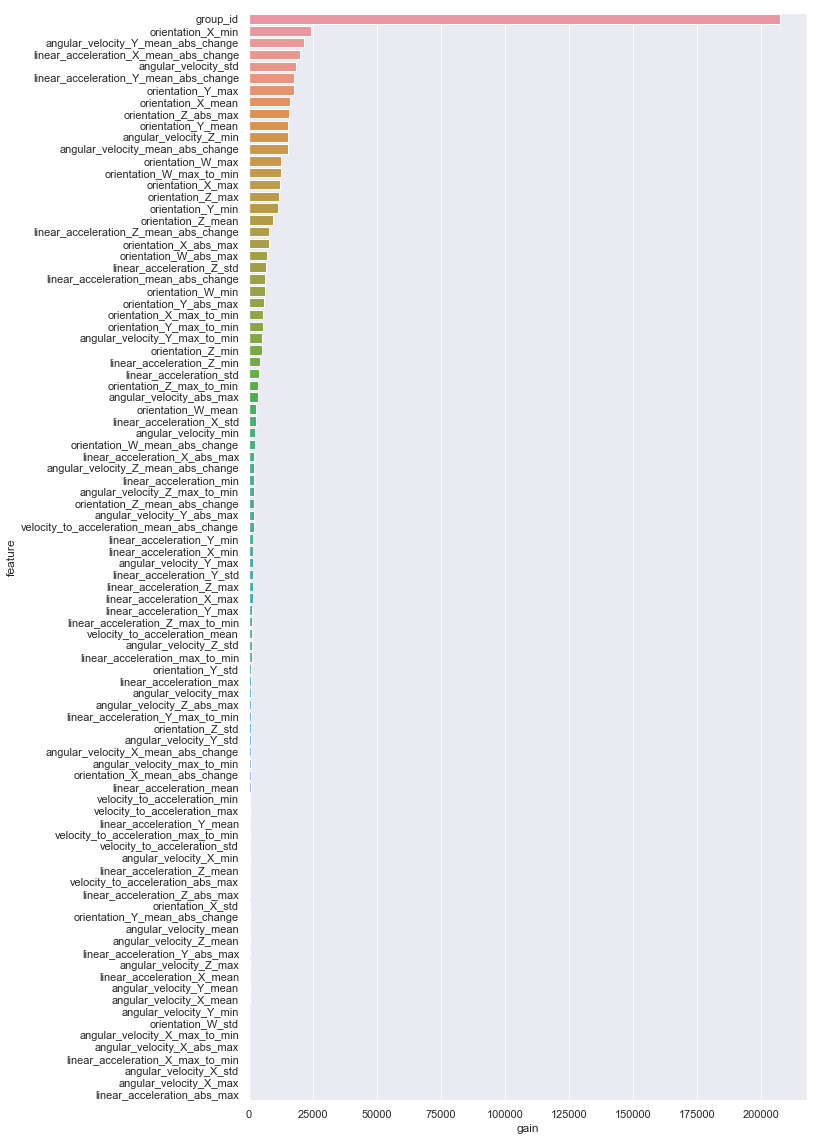

In [48]:
importance = pd.DataFrame({'gain': clf.feature_importance(importance_type='gain'),
                           'feature': clf.feature_name()})
importance.sort_values(by='gain', ascending=False, inplace=True)
plt.figure(figsize=(10, 20))
ax = sns.barplot(x='gain', y='feature', data=importance)

<h3>Work in progress...</h3>